# Ensambles

Question: Could be use data from minotiry solvents? Does it add value/relevant information?

Descriptions:
- 3 solvent availables, one majority and two minorities
- sample from majority and minorities: 3 samples
- train in majority
- evaluate in 3 samples and compare results, is there any particular improvement in majority?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from src.config import chemical_inventory_path, raw_data_path
from src.data import notebook_utils as utils
from src.constants import GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY, \
                        INCHI_TO_CHEMNAME, TARGET_COL, RXN_FEAT_NAME, ORGANOAMONIUM_INCHI_KEY_COL
from src import plot_utils

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.reload_library()
import matplotlib.patches as mpatches

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
import sklearn.ensemble as ensamble_models
import sklearn.neighbors as neighbors_models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model as linear_models
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [4]:
%cd ../..

/Users/mticona/Documents/tesis/licentiate-thesis-repo


In [14]:
PATH_DATA = 'data/ensemble/'
FILE_EVAL = 'validation_set.csv'
FILE_TEST_TRAIN = 'train_test_set.csv'

SEED = 1

In [24]:
df_test_train = pd.read_csv(PATH_DATA+FILE_TEST_TRAIN)

In [25]:
df_test_train.columns

Index(['Unnamed: 0', '_feat_WienerPolarity', '_feat_BondCount', '_feat_fr_NH0',
       '_feat_Refractivity', '_feat_LargestRingSize',
       '_feat_HeteroaliphaticRingCount', '_feat_fr_quatN',
       '_feat_AromaticAtomCount', '_feat_AtomCount_C', '_feat_fr_amidine',
       '_feat_CyclomaticNumber', '_feat_LengthPerpendicularToTheMinArea',
       '_feat_fr_guanido', '_feat_donorcount', '_feat_fr_NH2',
       '_feat_minimalprojectionsize', '_feat_AtomCount_N', '_feat_WienerIndex',
       '_feat_AvgPol', '_feat_donsitecount', '_feat_Hacceptorcount',
       '_feat_ASA-', '_feat_fr_Ar_NH', '_feat_HeteroaromaticRing Count',
       '_feat_Accsitecount', '_feat_acceptorcount', '_feat_ASA',
       '_feat_CarboaromaticRingCount', '_feat_BalabanIndex',
       '_feat_SmallestRingSize', '_feat_RingAtomCount',
       '_feat_PolarSurfaceArea', '_feat_MinimalProjectionArea',
       '_feat_MaximalProjectionArea', '_feat_CarboRingCount',
       '_feat_CarboaliphaticRingCount', '_feat_VanderWaalsSurface

In [26]:
df_test_train = df_test_train.drop(['Unnamed: 0','_rxn_organic-inchikey'], axis=1)

In [27]:
#df_test_train['groups'] = df_test_train.groupby([ORGANOAMONIUM_INCHI_KEY_COL]).grouper.group_info[0]

El estudio de la cristalización de perovskitas mediante aprendizaje automático encuentra desafíos comunes que surgen a la hora de trabajar con datos de experimentación, cuya disponibilidad suele ser muy acotada debido a la dificultad de su generación. De allí la relevancia de estudiar técnicas que permitan desarrollar modelos robusto y no sesgados por la representación que tiene una acotada cantidad de muestras. En este capítulo se estudia la aplicación del paradigma de ensamble mediante una comparación entre los tradicionales modelos homogéneos basados en árboles de decisión y modelos heterogénos específicos para el problema de cristalización de perovskita en particular.  

## Models definitions

Dentro del paradigma de ensamble, los métodos basados en árboles de decisión como estimador de base son los que más aplicación y popularidad han ganado en la última década. Características como lidear con datos categóricos, insensibilidad a la estandarización y XX, resultan que estos algoritmos sean atractivos por su versatilidad y la cantidad de problemas en donde pueden aplicarse.      

En general los métodos basados en árboles presentan sensiblidad a las particularedes del conjunto de entrenamiento, provocando un overfitting o sobre. De allí que los métodos más comúnmenmente empleados de ensambles usen estos tipo de estimadores

# comparar rf, gbc, 

Actualmente Entre los algoritmos más populares por su gran capacidad de generalizaci´pn 
Tradicionalmente se 


In [37]:
def make_model(model_name, model_config={}):
    try:
        model_method = getattr(neighbors_models, model_name)
    except AttributeError: 
        try:
            model_method = getattr(ensamble_models, model_name)
        except AttributeError:
            model_method = getattr(linear_models, model_name)
    
    model = model_method(**model_config)
    return model

def split_X_y(df):
    X = df.drop([TARGET_COL], axis=1).values
    y = df[TARGET_COL].values
    return X, y

def get_out_groups(df):
    df['groups'] = df.groupby([ORGANOAMONIUM_INCHI_KEY_COL]).grouper.group_info[0]
    groups = list(df['groups'])
    df = df.drop(['groups', ORGANOAMONIUM_INCHI_KEY_COL], axis=1)
    return df, groups

def proof_concept(model_name, df_train, df_test, model_config = {}):
    model = make_model(model_name, model_config)
    
    X_test, y_test = split_X_y(df_test)
    X_train, y_train = split_X_y(df_train)
    
    pipeline_steps = [('std', StandardScaler()), 
                      ('model', model)
                     ]
    
    pipeline = Pipeline(steps=pipeline_steps)
    
    pipeline.fit(X_train, y_train)
    
    y_pred =  pipeline.predict(X_test)
    
    matt = matthews_corrcoef(y_test, y_pred)
    
    report = classification_report(y_test, y_pred, labels=[0,1], 
                                   output_dict=True, target_names=["No cristaliza", "Cristaliza"])
    
    report_df =  pd.DataFrame(report).transpose()
    
    report_df["matthew"] = matt
    
    return report_df

def proof_concept_model(model_name, df_train, df_test, model_config = {}):
    model = make_model(model_name, model_config)
    
    X_test, y_test = split_X_y(df_test)
    X_train, y_train = split_X_y(df_train)
    
    pipeline_steps = [('std', StandardScaler()), 
                      ('model', model)
                     ]
    
    pipeline = Pipeline(steps=pipeline_steps)
    
    pipeline.fit(X_train, y_train)
    
    return pipeline
    
def full_pipeline(model_name, df, params):
    
    model = make_model(model_name)
    
    #df, groups = get_out_groups(df)  
    
    X, y = split_X_y(df)
    
    pipeline_steps = [('std', StandardScaler()), 
                      ('model', model)
                     ]
    pipeline = Pipeline(steps=pipeline_steps)
    
    k_fold_config = params['k_fold_config']
    
    params_search = params['params_search']
    
    cv = StratifiedShuffleSplit(**k_fold_config)

    scoring={
            'recall': 'recall', 
            'f1': 'f1',
            'precision': 'precision',
            'matthew': make_scorer(matthews_corrcoef)
    }
    optimizing_metric = 'matthew'
    
    clf = RandomizedSearchCV(pipeline,
                             params_search, 
                             cv=cv,
                             scoring=scoring,
                             random_state=SEED,
                             n_jobs=-1,
                             refit=optimizing_metric,
                             error_score=0,
                             n_iter=params['n_iter'],
                            )
    clf.fit(X, y)
    
    return clf

In [38]:
results_path = 'results/ensamble/'

models = {
    'knn':'KNeighborsClassifier',
    'rf':'RandomForestClassifier',
    'gbc':'GradientBoostingClassifier'
}

grid_params_rf_default = dict(
                      model__min_samples_split=[10,7,15,20],
                      model__min_samples_leaf=[3,4,5,6],
                      model__warm_start=[False],
                      model__class_weight=[None, 'balanced', 'balanced_subsample']
                     )

k_splits = 2

k_fold_config_default = {
    'random_state': SEED,
    #'shuffle': True,
    'n_splits': k_splits
}

params_example = {
    'k_fold_config': k_fold_config_default,
    'params_search': grid_params_rf_default,
    'n_iter': 300
}

In [59]:
# parameters exploration

def run_param_exploration_rf(model__max_depth, model__n_estimators,
                          n_iter=100, 
                          k_fold_config=k_fold_config_default,
                          file_name='no_file_name.csv'):
    grid_params_rf = grid_params_rf_default.copy()
    grid_params_rf['model__n_estimators'] = model__n_estimators
    grid_params_rf['model__max_depth'] = model__max_depth
    params = {
        'k_fold_config': k_fold_config,
        'params_search': grid_params_rf,
        'n_iter': n_iter
    }
    gs = full_pipeline(models['rf'], df_test_train, params)
    df_res = pd.DataFrame.from_dict(gs.cv_results_)
    df_res.to_csv(results_path+file_name, index=None)
    return df_res

In [60]:
# explore depth
model__max_depth=[4,5,7, 11,13, 15, 16, 17, 20]
model__n_estimators=[100]
file_depth = 'rf_explore_max_depth_class_balanced.csv'
df_exp_depth = run_param_exploration_rf(model__max_depth, model__n_estimators, file_name=file_depth,
                                       n_iter=600)

/Users/mticona/.local/share/virtualenvs/licentiate-thesis-repo-_Hfi4eev/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 432 is smaller than n_iter=600. Running 432 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


<AxesSubplot:xlabel='param_model__max_depth', ylabel='mean_test_matthew'>

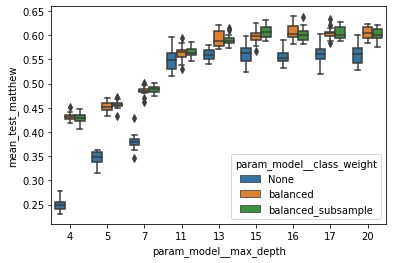

In [67]:
df_exp_depth_ = df_exp_depth.fillna('None')

sns.boxplot(x=df_exp_depth_['param_model__max_depth'], y=df_exp_depth_['mean_test_matthew'], 
                hue=df_exp_depth_['param_model__class_weight'])
#plt.savefig('explore_depth_balanced_600.pdf', dpi=300)

In [78]:
def get_models_by_class(class_weigths=[None, 'balanced', 'balanced_subsample'], k_fold_config=k_fold_config_default, n_iter=40):
    grid_params_rf = grid_params_rf_default.copy()
    grid_params_rf['model__n_estimators'] = [130]
    grid_params_rf['model__max_depth'] = [11]
    class_models = []
    for model_class in class_weigths:
        grid_params_rf['model__class_weight'] = [model_class]
                 
        params = {
            'k_fold_config': k_fold_config,
            'params_search': grid_params_rf,
            'n_iter': n_iter
        }
        gs = full_pipeline(models['rf'], df_test_train, params)
        class_models.append(gs)
    return class_models

In [79]:
class_models = get_models_by_class()

/Users/mticona/.local/share/virtualenvs/licentiate-thesis-repo-_Hfi4eev/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 16 is smaller than n_iter=40. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/mticona/.local/share/virtualenvs/licentiate-thesis-repo-_Hfi4eev/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 16 is smaller than n_iter=40. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/mticona/.local/share/virtualenvs/licentiate-thesis-repo-_Hfi4eev/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 16 is smaller than n_iter=40. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [98]:
df_test_train.columns[:-1]

Index(['_feat_WienerPolarity', '_feat_BondCount', '_feat_fr_NH0',
       '_feat_Refractivity', '_feat_LargestRingSize',
       '_feat_HeteroaliphaticRingCount', '_feat_fr_quatN',
       '_feat_AromaticAtomCount', '_feat_AtomCount_C', '_feat_fr_amidine',
       '_feat_CyclomaticNumber', '_feat_LengthPerpendicularToTheMinArea',
       '_feat_fr_guanido', '_feat_donorcount', '_feat_fr_NH2',
       '_feat_minimalprojectionsize', '_feat_AtomCount_N', '_feat_WienerIndex',
       '_feat_AvgPol', '_feat_donsitecount', '_feat_Hacceptorcount',
       '_feat_ASA-', '_feat_fr_Ar_NH', '_feat_HeteroaromaticRing Count',
       '_feat_Accsitecount', '_feat_acceptorcount', '_feat_ASA',
       '_feat_CarboaromaticRingCount', '_feat_BalabanIndex',
       '_feat_SmallestRingSize', '_feat_RingAtomCount',
       '_feat_PolarSurfaceArea', '_feat_MinimalProjectionArea',
       '_feat_MaximalProjectionArea', '_feat_CarboRingCount',
       '_feat_CarboaliphaticRingCount', '_feat_VanderWaalsSurfaceArea',
       

In [109]:
def plot_features_importances(model, columns, k_first=10):
    (pd.Series(model.best_estimator_.named_steps['model'].feature_importances_, 
               index=columns)
       .nlargest(k_first)
       .plot(kind='barh'))        # some method chaining, because it's sexy!

In [117]:
df_test_train.columns[:-1]

Index(['_feat_WienerPolarity', '_feat_BondCount', '_feat_fr_NH0',
       '_feat_Refractivity', '_feat_LargestRingSize',
       '_feat_HeteroaliphaticRingCount', '_feat_fr_quatN',
       '_feat_AromaticAtomCount', '_feat_AtomCount_C', '_feat_fr_amidine',
       '_feat_CyclomaticNumber', '_feat_LengthPerpendicularToTheMinArea',
       '_feat_fr_guanido', '_feat_donorcount', '_feat_fr_NH2',
       '_feat_minimalprojectionsize', '_feat_AtomCount_N', '_feat_WienerIndex',
       '_feat_AvgPol', '_feat_donsitecount', '_feat_Hacceptorcount',
       '_feat_ASA-', '_feat_fr_Ar_NH', '_feat_HeteroaromaticRing Count',
       '_feat_Accsitecount', '_feat_acceptorcount', '_feat_ASA',
       '_feat_CarboaromaticRingCount', '_feat_BalabanIndex',
       '_feat_SmallestRingSize', '_feat_RingAtomCount',
       '_feat_PolarSurfaceArea', '_feat_MinimalProjectionArea',
       '_feat_MaximalProjectionArea', '_feat_CarboRingCount',
       '_feat_CarboaliphaticRingCount', '_feat_VanderWaalsSurfaceArea',
       

[None]

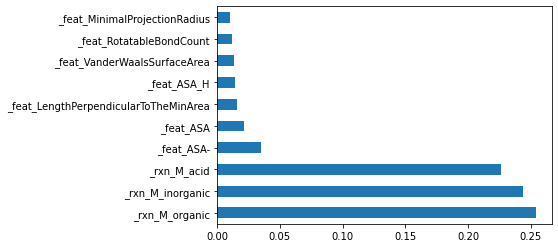

In [114]:
[plot_features_importances(class_models[0], df_test_train.columns[:-1]) for i in range(0,1)]

[None]

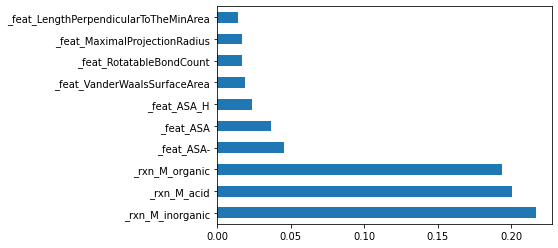

In [115]:
[plot_features_importances(class_models[1], df_test_train.columns[:-1]) for i in range(0,1)]

[None]

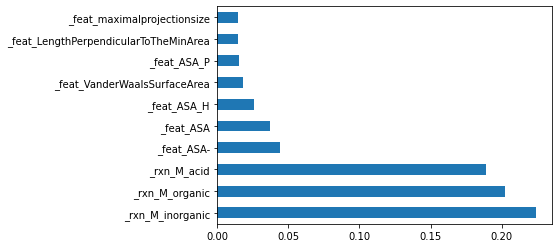

In [116]:
[plot_features_importances(class_models[2], df_test_train.columns[:-1]) for i in range(0,1)]

In [108]:
class_models[0].best_estimator_.named_steps['model'].feature_importances_

array([2.33847074e-03, 8.02840655e-03, 9.04147432e-05, 6.44974218e-03,
       9.25363327e-04, 8.90391393e-05, 4.50903876e-04, 9.80000810e-04,
       2.64778000e-03, 5.59737196e-04, 2.59471978e-04, 1.62380832e-02,
       2.80940210e-04, 3.25856697e-04, 1.39994833e-03, 8.03273840e-03,
       8.77377581e-04, 4.96623480e-03, 9.41092822e-03, 9.09473522e-04,
       1.28569687e-03, 3.47089129e-02, 0.00000000e+00, 0.00000000e+00,
       1.20953448e-03, 1.03944466e-03, 2.15150964e-02, 1.92928077e-04,
       5.04712242e-03, 9.42976930e-04, 5.62555390e-04, 1.97615236e-03,
       8.84428083e-03, 7.22984079e-03, 8.02442421e-04, 2.95946814e-03,
       1.34139562e-02, 1.40035979e-02, 7.40386132e-03, 0.00000000e+00,
       6.28304799e-03, 5.93434189e-03, 3.22671839e-04, 6.21536280e-03,
       3.31279546e-03, 6.49473273e-03, 3.22392055e-04, 1.16512000e-02,
       8.10258669e-03, 4.43661411e-03, 1.03654558e-02, 7.35303251e-03,
       6.53385713e-03, 1.47771308e-04, 8.80388703e-03, 1.85149095e-03,
      

In [94]:
class_models[0].best_estimator_.named_steps['model'].feature_importances_.shape

(60,)

In [105]:
class_models[1].best_estimator_.named_steps['model'].feature_importances_

array([6.78819475e-03, 5.17709670e-03, 2.23520290e-04, 1.35072357e-02,
       8.95623567e-04, 9.30079790e-05, 5.96308759e-04, 1.47956516e-03,
       3.25503350e-03, 8.41425846e-04, 8.48107141e-04, 1.44205826e-02,
       3.94944539e-04, 4.81960518e-04, 1.56034747e-03, 1.20391008e-02,
       1.55046709e-03, 9.79972343e-03, 8.63955080e-03, 9.86456079e-04,
       9.60589669e-04, 4.54653292e-02, 0.00000000e+00, 0.00000000e+00,
       8.90569998e-04, 7.21957030e-04, 3.70087965e-02, 9.78237831e-04,
       5.67132017e-03, 7.96033503e-04, 9.02252305e-04, 2.57845277e-03,
       1.01757987e-02, 1.12005106e-02, 3.70879344e-04, 5.80380443e-03,
       1.87815189e-02, 2.34681429e-02, 1.10558282e-02, 0.00000000e+00,
       5.40756363e-03, 4.75998243e-03, 1.81782223e-03, 1.20272463e-02,
       5.87442327e-03, 5.78950816e-03, 1.67089939e-04, 1.71900255e-02,
       1.41180332e-02, 1.37707753e-02, 9.10636271e-03, 1.14454698e-02,
       9.00637339e-03, 3.34068960e-04, 1.69836377e-02, 1.43243694e-03,
      

In [93]:
class_models[2].best_estimator_.named_steps['model'].feature_importances_

array([5.80930023e-03, 7.66359258e-03, 1.51322519e-04, 8.92312634e-03,
       1.13907207e-03, 1.54661275e-04, 4.28270282e-04, 7.64999812e-04,
       2.65146968e-03, 3.25093362e-04, 1.11112996e-03, 1.50453461e-02,
       6.86567410e-05, 6.82887333e-04, 1.73194616e-03, 8.39223715e-03,
       1.95156933e-03, 6.17323389e-03, 1.05171921e-02, 5.99667755e-04,
       1.04185981e-03, 4.44713816e-02, 0.00000000e+00, 0.00000000e+00,
       1.45650474e-03, 1.02745642e-03, 3.75965502e-02, 1.05675768e-03,
       5.33173970e-03, 7.75982371e-04, 9.86617050e-04, 2.46905573e-03,
       7.79879819e-03, 8.42460016e-03, 8.53323397e-04, 2.71077006e-03,
       1.83981654e-02, 2.60198551e-02, 1.29270923e-02, 0.00000000e+00,
       7.57170112e-03, 4.01515023e-03, 5.62585650e-04, 1.43245883e-02,
       6.63769240e-03, 8.52212662e-03, 1.69380321e-04, 1.32980583e-02,
       1.47655396e-02, 1.44857328e-02, 8.37604480e-03, 1.13338399e-02,
       1.57719491e-02, 2.45991033e-04, 1.47363819e-02, 2.08814022e-03,
      

In [64]:
# explore estimators
model__n_estimators=np.arange(10, 350, 50)
model__max_depth=[9]
file_estimators = 'rf_explore_n_estimators_balanced_1000.csv'
df_exp_estimators = run_param_exploration_rf(model__max_depth, model__n_estimators, 
                                             n_iter=1000,
                                             file_name=file_estimators)

/Users/mticona/.local/share/virtualenvs/licentiate-thesis-repo-_Hfi4eev/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 336 is smaller than n_iter=1000. Running 336 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


<AxesSubplot:xlabel='param_model__n_estimators', ylabel='mean_test_matthew'>

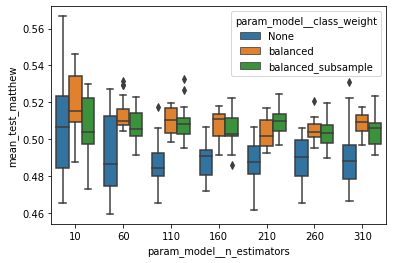

In [65]:
df_exp_estimators_ = df_exp_estimators.fillna('None')

sns.boxplot(x=df_exp_estimators_['param_model__n_estimators'], y=df_exp_estimators_['mean_test_matthew'], 
                hue=df_exp_estimators_['param_model__class_weight'])
#plt.savefig('explore_estimators_1000.pdf', dpi=300)

In [35]:
df_cv_res = pd.concat([pd.DataFrame(gs.cv_results_["params"]),
                       pd.DataFrame(gs.cv_results_["mean_test_matthew"], columns=["matthew"]),
                      pd.DataFrame(gs.cv_results_["mean_test_precision"], columns=["precision"]),
                      pd.DataFrame(gs.cv_results_["mean_test_f1"], columns=["f1"]),
                      pd.DataFrame(gs.cv_results_["rank_test_matthew"], columns=["rank_test_matthew"]),
                       pd.DataFrame(gs.cv_results_["mean_test_recall"], columns=["recall"])],axis=1)

NameError: name 'gs' is not defined

In [42]:
import seaborn as sns

In [ ]:
df_exp_estimators = pd.read_csv(results_path+file_estimators)
df_exp_depth = pd.read_csv(results_path+file_depth)

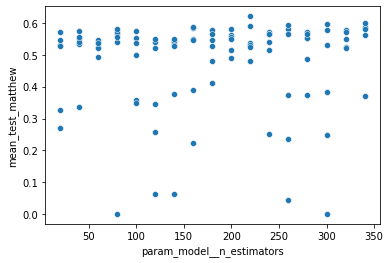

In [284]:
sns.scatterplot(x=df_exp_estimators['param_model__n_estimators'], y=df_exp_depth['mean_test_matthew'])
plt.savefig('explore_estimators.pdf', dpi=300)

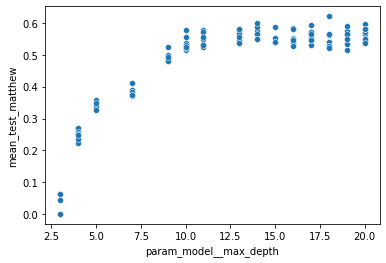

In [285]:
sns.scatterplot(x=df_exp_depth['param_model__max_depth'], y=df_exp_depth['mean_test_matthew'])
plt.savefig('explore_depth.pdf', dpi=300)

## Experiments

### Experiment 1: diversity by parameters

In [265]:
ranges_n_estimators = {
    'bajo_estimators': np.arange(50, 150, 20),
    'med_estimators': np.arange(150, 250, 20),
    'alto_estimators': np.arange(250, 350, 20)
}

range_depth = {
    'bajo_depth': np.arange(4, 8, 1),
    'med_depth': np.arange(8, 12, 1),
    'alto_depth': np.arange(12, 16, 1)
}

In [266]:
from joblib import dump, load

In [267]:
# parameters exploration
estimators_dir = results_path+'exp_params/estimators/'
grid_dir = results_path+'exp_params/grid_results/'

def run_params_combinations(ranges_n_estimators, range_depth,
                          n_iter=1, 
                          k_fold_config=k_fold_config_default,
                          file_name='no_file_name.csv'):
    best_estimators = []
    name_estimators = []
    for range_name_est, estimators_ls in ranges_n_estimators.items():
        for range_name_depth, depth_ls in range_depth.items():
            file_name = range_name_est + '_' + range_name_depth 
            grid_params_rf = grid_params_rf_default.copy()
            grid_params_rf['model__n_estimators'] = list(estimators_ls)
            grid_params_rf['model__max_depth'] = list(depth_ls)
            params = {
                'k_fold_config': k_fold_config,
                'params_search': grid_params_rf,
                'n_iter': n_iter
            }
            gs = full_pipeline(models['rf'], df_test_train, params)
            
            df_res = pd.DataFrame.from_dict(gs.cv_results_)
            df_res.to_csv(grid_dir+file_name+'.csv', index=None)
            
            dump(gs.best_estimator_,  estimators_dir + file_name +'.joblib')
            
            best_estimators.append(gs.best_estimator_)
            best_estimators.append(gs.best_estimator_)
            best_estimators.append(file_name)
            
    return best_estimators, name_estimators

In [268]:
best_estimators, name_estimators = run_params_combinations(ranges_n_estimators, range_depth)

In [275]:
df = df_test_train.drop(['_rxn_organic-inchikey', 'groups'], axis=1)

In [276]:
X, y = split_X_y(df)

In [ ]:
best_estimators.best_estimators

In [259]:
# Somewhere else
estimator = load(estimators_dir+"test-model.joblib")

In [249]:
run_params_combinations(ranges_n_estimators, range_depth)

{'k_fold_config': {'random_state': 1, 'n_splits': 2}, 'params_search': {'model__min_samples_split': [10, 7, 15, 20], 'model__min_samples_leaf': [3, 6], 'model__warm_start': [False], 'model__class_weight': [None], 'model__n_estimators': [50, 70, 90, 110, 130], 'model__max_depth': [4, 5, 6, 7]}, 'n_iter': 100}
{'k_fold_config': {'random_state': 1, 'n_splits': 2}, 'params_search': {'model__min_samples_split': [10, 7, 15, 20], 'model__min_samples_leaf': [3, 6], 'model__warm_start': [False], 'model__class_weight': [None], 'model__n_estimators': [50, 70, 90, 110, 130], 'model__max_depth': [8, 9, 10, 11]}, 'n_iter': 100}
{'k_fold_config': {'random_state': 1, 'n_splits': 2}, 'params_search': {'model__min_samples_split': [10, 7, 15, 20], 'model__min_samples_leaf': [3, 6], 'model__warm_start': [False], 'model__class_weight': [None], 'model__n_estimators': [50, 70, 90, 110, 130], 'model__max_depth': [12, 13, 14, 15]}, 'n_iter': 100}
{'k_fold_config': {'random_state': 1, 'n_splits': 2}, 'params_se

In [129]:
# Experiments 1
# test in a MULTISOLVENT sample (encoded)
# test in same sample but without encoded solvent feature
def exp_drop_solvent(model_name, df_train, df_test, model_config = {}):
    drop_cols = ['solvent_Dimethyl sulfoxide', 
                 'solvent_Dimethylformamide',
                 'solvent_Gamma-Butyrolactone']
    df_train = df_train.drop(drop_cols, axis=1)
    df_test = df_test.drop(drop_cols, axis=1)
    return proof_concept(model_name, df_train, df_test)

ALGORITHMS = ['rf']

results_dir = "solvent_exp_1"

model_EVAL_MULTISOLVENT = EVAL_MULTISOLVENT.drop(['solvent'], axis=1)

model_df_solvent_full_train = df_solvent_full_train.drop(['solvent'], axis=1)


for ALGORITH in ALGORITHMS:
    results_experiment_1 = proof_concept(models[ALGORITHM], model_df_solvent_full_train, model_EVAL_MULTISOLVENT,
                                        model_configs[ALGORITHM])

    results_experiment_s_sv = exp_drop_solvent(models[ALGORITHM], model_df_solvent_full_train, model_EVAL_MULTISOLVENT,
                                        model_configs[ALGORITHM])

    report_multisv =  pd.DataFrame(results_experiment_1).transpose()
    report_no_sol =  pd.DataFrame(results_experiment_s_sv).transpose()
    
    report_multisv.to_csv(results_dir+"eval_multisolvente_encoded_%s_%s.csv" % (SEED, ALGORITH), index=None)

    report_no_sol.to_csv(results_dir+"eval_no_solvent_%s_%s.csv" % (SEED, ALGORITH), index=None)

In [139]:
report_multisv.transpose()

,No cristaliza,Cristaliza,accuracy,macro avg,weighted avg
precision,0.935294,0.650000,0.880952,0.792647,0.885028
recall,0.919075,0.702703,0.880952,0.810889,0.880952
f1-score,0.927114,0.675325,0.880952,0.801219,0.882751
support,173.000000,37.000000,0.880952,210.000000,210.000000


In [140]:
report_no_sol

,No cristaliza,Cristaliza,accuracy,macro avg,weighted avg
precision,0.916993,0.740909,0.891116,0.828951,0.885352
recall,0.953583,0.605948,0.891116,0.779766,0.891116
f1-score,0.934930,0.666667,0.891116,0.800798,0.886725
support,1228.000000,269.000000,0.891116,1497.000000,1497.000000


In [125]:
# Experimento 2
dir_results = "results_exp_2/"

for solvent in solvents:
    drop_cols = ['solvent_Dimethyl sulfoxide', 
                 'solvent_Dimethylformamide',
                 'solvent_Gamma-Butyrolactone',
                'solvent']
    
    df_train_sv = df_solvent_full_train[df_solvent_full_train.solvent == solvent].drop(drop_cols, axis=1)
    
    df_test_sv = EVAL_MULTISOLVENT[EVAL_MULTISOLVENT.solvent == solvent].drop(drop_cols, axis=1)
    
    df_test_sv_encoded = EVAL_MULTISOLVENT[EVAL_MULTISOLVENT.solvent == solvent].drop('solvent', axis=1)
    df_train_sv_encoded = df_solvent_full_train.drop('solvent', axis=1)
    
    # modelo específico por solvente
    report_sv = proof_concept(models[ALGORITHM], df_train_sv, df_test_sv,
                              model_configs[ALGORITHM])
                              
    
    # misma muestra en modelo multisolvente
    report_multisv = proof_concept(models[ALGORITHM], df_train_sv_encoded, df_test_sv_encoded,
                                   model_configs[ALGORITHM])
                                   
    
    report_sv.to_csv(dir_results+'model_per_solv_%s_%s.csv' % (SEED, solvent), index=None)
    report_multisv.to_csv(dir_results+'sample_%s_%s_in_multisolvent.csv' % (SEED, solvent), index=None)

In [144]:
report_sv["matthew"] = 3

In [145]:
report_sv

,precision,recall,f1-score,support,matthew
No cristaliza,0.934911,0.913295,0.923977,173.00000,3
Cristaliza,0.634146,0.702703,0.666667,37.00000,3
accuracy,0.876190,0.876190,0.876190,0.87619,3
macro avg,0.784529,0.807999,0.795322,210.00000,3
weighted avg,0.881919,0.876190,0.878641,210.00000,3


Features importances only computed for RandomForest

In [1058]:
ALGORITHM

'rf'

In [1059]:
df_solvent_models = {solvent: proof_concept_model(models[ALGORITHM], df_solvent_full_train, df_test) \
                        for solvent, df_test in df_solvent_samples_test.items() }

model_cols = list(df_solvent_full_train.columns)
model_cols.remove(TARGET_COL)

df_importance = pd.DataFrame({"feature": model_cols,
                             "importance": df_solvent_models['Gamma-Butyrolactone']['model'].feature_importances_})
df_importance = df_importance.sort_values(by="importance", ascending=False)

In [1060]:
#df_importance.to_csv("results/solvent-exp/random_forest_feat_importances.csv", index=None)

df_importance = pd.read_csv("random_forest_feat_importances.csv")

In [1061]:
#df_importance.reset_index().head(50)

plot_title = "figures/feature_importances.pdf"
def plot_df_importances(df):
    with plt.style.context(['science', 'bright']):
        #sns.set_palette(sns.color_palette(color_bright))
        fig, axes = plt.subplots(1, 1, figsize=(8,5),
                                     constrained_layout = True)
        ax = sns.barplot(x="importance", y="feature", orient="h", data=df,
                         palette=df.color, alpha=0.7)
        #ax.set_title("Distribución Calidad de Cristal")

        # Remove box lines
        sns.despine(bottom = True, left = False, trim=False)
        ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        #ax.xticks(fontdict={'fontsize':15})
        #ax.tick_params(axis='both', which='both')
        ax.set_ylabel("Importancia", fontdict={'fontsize':13})
        ax.set_xlabel("Variable", fontdict={'fontsize':13}, rotation=0)
        #ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
        #plt.xticks()
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=12)


    #        ax.annotate(text, (x, y), ha='center', va='center', fontsize=12)

        #plt.legend(title="Tipo de Variable", fontsize=13)
        plt.xlim(0,0.015)
        fig.savefig(plot_title, dpi=300)

In [1062]:
# fronteroa  de toma de posición 
# misma superficie no cambia tanto 
# por qupe tan bajo peso

# combinar modelos
# binarización más fuerte

indexes = np.arange(0,60,6)

tmp = df_importance.iloc[3:,:].reset_index(drop=True)
#.reset_index(drop=True).loc[indexes]

tmp['color'] = np.where(tmp['feature'].str.startswith("solvent"), 'red', 'grey')

solvent_index = tmp[tmp.feature.str.startswith("solvent")].index

plot_df_importances(tmp.iloc[list(indexes) + list(solvent_index)]\
                    .sort_values(by="importance", ascending=False))